Files already downloaded and verified


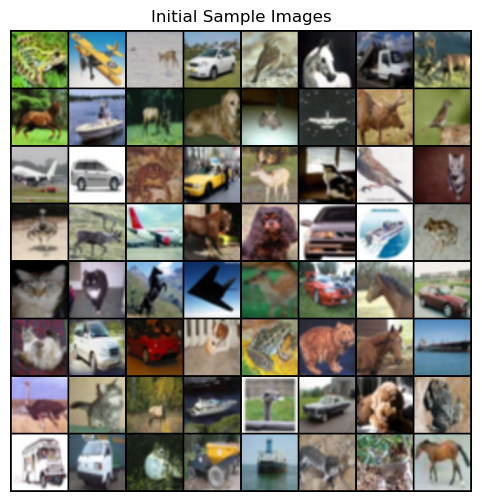

In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

# Parameters
MODEL_PARAMS = {
    'epochs': 50,
    'batch_size': 128,
    'learning_rate': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    'noise_dim': 100,
    'num_classes': 10,  # CIFAR-10 has 10 classes
    'image_size': 64,
    'channels': 3,
    'gen_features': 64,
    'disc_features': 64,
}

# Setup directories
RESULTS_PATH = "ACGAN_results"
os.makedirs(os.path.join(RESULTS_PATH, "GeneratedImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_PATH, "RealImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_PATH, "Metrics"), exist_ok=True)

# Device configuration
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform_pipeline = transforms.Compose([
    transforms.Resize(MODEL_PARAMS['image_size']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
cifar_data = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_pipeline)
cifar_loader = DataLoader(cifar_data, 
                         batch_size=MODEL_PARAMS['batch_size'], 
                         shuffle=True, 
                         num_workers=2, 
                         pin_memory=True)

# Display initial samples
initial_samples = next(iter(cifar_loader))
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Initial Sample Images")
plt.imshow(np.transpose(utils.make_grid(initial_samples[0][:64], padding=2, normalize=True), (1, 2, 0)))
plt.show()

In [2]:
# Cell 2: Generator and Discriminator Models
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, num_classes=10):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, nz)
        
        self.main = nn.Sequential(
            # Input is Z + embedded label, going into a convolution
            nn.ConvTranspose2d(nz * 2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8, momentum=0.9),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4, momentum=0.9),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2, momentum=0.9),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf, momentum=0.9),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)
        label_embedding = label_embedding.view(-1, MODEL_PARAMS['noise_dim'], 1, 1)
        concat_input = torch.cat((noise, label_embedding), 1)
        return self.main(concat_input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, num_classes=10):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8, momentum=0.9),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Source prediction (real/fake)
        self.source = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # Class prediction
        self.classifier = nn.Sequential(
            nn.Conv2d(ndf * 8, num_classes, 4, 1, 0, bias=False)
        )
        
    def forward(self, x):
        features = self.main(x)
        validity = self.source(features)
        class_pred = self.classifier(features)
        return validity.view(-1, 1), class_pred.view(-1, MODEL_PARAMS['num_classes'])

def weight_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [3]:
# Cell 3: Inception Model for Metrics
class QualityMetrics(nn.Module):
    def __init__(self):
        super(QualityMetrics, self).__init__()
        inception = models.inception_v3(pretrained=True)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block3 = nn.Sequential(
            inception.Mixed_5b, inception.Mixed_5c,
            inception.Mixed_5d, inception.Mixed_6a,
            inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e
        )
        self.block4 = nn.Sequential(
            inception.Mixed_7a, inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )
        
    def forward(self, x):
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = 2 * x - 1
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.view(x.size(0), -1)

metrics_model = QualityMetrics().to(device)
metrics_model.eval()

def get_feature_stats(images, model):
    with torch.no_grad():
        pred = model(images)
        mu = pred.mean(dim=0).cpu().numpy()
        sigma = np.cov(pred.cpu().numpy(), rowvar=False)
    return mu, sigma

def calculate_statistical_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def compute_quality_score(real_imgs, fake_imgs, model):
    mu1, sigma1 = get_feature_stats(real_imgs, model)
    mu2, sigma2 = get_feature_stats(fake_imgs, model)
    return calculate_statistical_distance(mu1, sigma1, mu2, sigma2)

/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pchouda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Cell 4: Image Saving and Plot Functions
def save_images(epoch, real_imgs, fake_imgs):
    utils.save_image(
        real_imgs, 
        os.path.join(RESULTS_PATH, f'RealImages/real_epoch_{epoch}.png'),
        normalize=True
    )
    utils.save_image(
        fake_imgs,
        os.path.join(RESULTS_PATH, f'GeneratedImages/generated_epoch_{epoch}.png'),
        normalize=True
    )

def plot_training_curves(gen_losses, disc_losses, class_accuracies, quality_scores, disc_accuracies):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(gen_losses, label='Generator')
    plt.plot(disc_losses, label='Discriminator')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Network Losses')
    
    plt.subplot(2, 2, 2)
    plt.plot(quality_scores)
    plt.xlabel('Epoch')
    plt.ylabel('FID Score')
    plt.title('Quality Metrics')
    
    plt.subplot(2, 2, 3)
    plt.plot(disc_accuracies, label='Real/Fake')
    plt.plot(class_accuracies, label='Classification')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Discriminator Performance')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'Metrics/training_curves.png'))
    plt.show()

In [5]:
# Cell 5: Training Function
def train_networks(gen_model, disc_model, dataloader, num_epochs=MODEL_PARAMS['epochs']):
    gen_losses = []
    disc_losses = []
    class_accuracies = []
    quality_metrics = []
    disc_accuracies = []
    training_log = open(os.path.join(RESULTS_PATH, "Metrics/training_log.txt"), "w")
    
    # ACGAN losses
    adversarial_loss = nn.BCELoss()
    auxiliary_loss = nn.CrossEntropyLoss()
    
    # Fixed noise and labels for visualization
    fixed_noise = torch.randn(64, MODEL_PARAMS['noise_dim'], 1, 1, device=device)
    fixed_labels = torch.tensor([i // 8 for i in range(64)], device=device)
    
    # Optimizers
    g_optimizer = optim.Adam(gen_model.parameters(), 
                            lr=MODEL_PARAMS['learning_rate'], 
                            betas=(MODEL_PARAMS['beta1'], MODEL_PARAMS['beta2']))
    d_optimizer = optim.Adam(disc_model.parameters(), 
                            lr=MODEL_PARAMS['learning_rate'], 
                            betas=(MODEL_PARAMS['beta1'], MODEL_PARAMS['beta2']))
    
    print("Beginning Training Process...")
    
    for epoch in range(num_epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        correct_disc = 0
        correct_class = 0
        total_samples = 0
        
        for batch_idx, (real_images, real_labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            
            # Ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)
            
            # -----------------
            # Train Discriminator
            # -----------------
            d_optimizer.zero_grad()
            
            # Real images
            real_pred, real_aux = disc_model(real_images)
            d_real_loss = adversarial_loss(real_pred, valid)
            # ACGAN: Classification loss for real images
            d_real_aux_loss = auxiliary_loss(real_aux, real_labels)
            
            # Fake images
            noise = torch.randn(batch_size, MODEL_PARAMS['noise_dim'], 1, 1, device=device)
            gen_labels = torch.randint(0, MODEL_PARAMS['num_classes'], (batch_size,), device=device)
            # ACGAN: Conditional generation
            fake_images = gen_model(noise, gen_labels)
            fake_pred, fake_aux = disc_model(fake_images.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)
            # ACGAN: Classification loss for fake images
            d_fake_aux_loss = auxiliary_loss(fake_aux, gen_labels)
            
            # Total discriminator loss
            # ACGAN: Total discriminator loss combines both source and class predictions
            d_loss = (d_real_loss + d_fake_loss) / 2 + (d_real_aux_loss + d_fake_aux_loss) / 2
            d_loss.backward()
            d_optimizer.step()
            
            # Calculate discriminator accuracy
            pred_real = (real_pred > 0.5).float()
            pred_fake = (fake_pred > 0.5).float()
            correct_disc += (pred_real == valid).sum().item() + (pred_fake == fake).sum().item()
            
            # Calculate classification accuracy
            _, pred_label = torch.max(real_aux.data, 1)
            correct_class += (pred_label == real_labels).sum().item()
            
            total_samples += batch_size * 2
            
            # -----------------
            # Train Generator
            # -----------------
            g_optimizer.zero_grad()
            
            validity, aux_scores = disc_model(fake_images)
            g_loss = adversarial_loss(validity, valid) + auxiliary_loss(aux_scores, gen_labels)
            
            g_loss.backward()
            g_optimizer.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(dataloader)}] '
                      f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')
        
        # Calculate epoch metrics
        disc_accuracy = (correct_disc / (total_samples)) * 100
        class_accuracy = (correct_class / (total_samples/2)) * 100
        avg_d_loss = epoch_d_loss / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        # Generate images for visualization
        with torch.no_grad():
            gen_images = gen_model(fixed_noise, fixed_labels)
            quality_score = compute_quality_score(real_images[:64], gen_images, metrics_model)
            save_images(epoch, real_images[:64], gen_images)
        
        # Log results
        log_entry = (f"Epoch {epoch}: D_Loss={avg_d_loss:.4f}, G_Loss={avg_g_loss:.4f}, "
                    f"Disc_Acc={disc_accuracy:.2f}%, Class_Acc={class_accuracy:.2f}%, "
                    f"Quality={quality_score:.4f}\n")
        training_log.write(log_entry)
        print(log_entry)
        
        gen_losses.append(avg_g_loss)
        disc_losses.append(avg_d_loss)
        disc_accuracies.append(disc_accuracy)
        class_accuracies.append(class_accuracy)
        quality_metrics.append(quality_score)
    
    training_log.close()
    return gen_losses, disc_losses, class_accuracies, quality_metrics, disc_accuracies

Training on cuda
Beginning Training Process...
Epoch [0/50] Batch [0/391] D_loss: 2.9956 G_loss: 2.9947
Epoch [0/50] Batch [100/391] D_loss: 0.9622 G_loss: 3.3185
Epoch [0/50] Batch [200/391] D_loss: 0.8468 G_loss: 4.4101
Epoch [0/50] Batch [300/391] D_loss: 1.1005 G_loss: 1.3640
Epoch 0: D_Loss=1.1718, G_Loss=2.9096, Disc_Acc=91.85%, Class_Acc=44.48%, Quality=379.9142

Epoch [1/50] Batch [0/391] D_loss: 1.1295 G_loss: 0.9401
Epoch [1/50] Batch [100/391] D_loss: 1.0879 G_loss: 1.2814
Epoch [1/50] Batch [200/391] D_loss: 1.2190 G_loss: 1.4274
Epoch [1/50] Batch [300/391] D_loss: 1.2233 G_loss: 1.5255
Epoch 1: D_Loss=1.1562, G_Loss=1.9373, Disc_Acc=79.45%, Class_Acc=54.30%, Quality=343.9136

Epoch [2/50] Batch [0/391] D_loss: 1.1156 G_loss: 2.2561
Epoch [2/50] Batch [100/391] D_loss: 1.1171 G_loss: 1.7743
Epoch [2/50] Batch [200/391] D_loss: 0.9532 G_loss: 1.7138
Epoch [2/50] Batch [300/391] D_loss: 1.0416 G_loss: 2.0484
Epoch 2: D_Loss=1.1252, G_Loss=2.0840, Disc_Acc=79.44%, Class_Acc=5

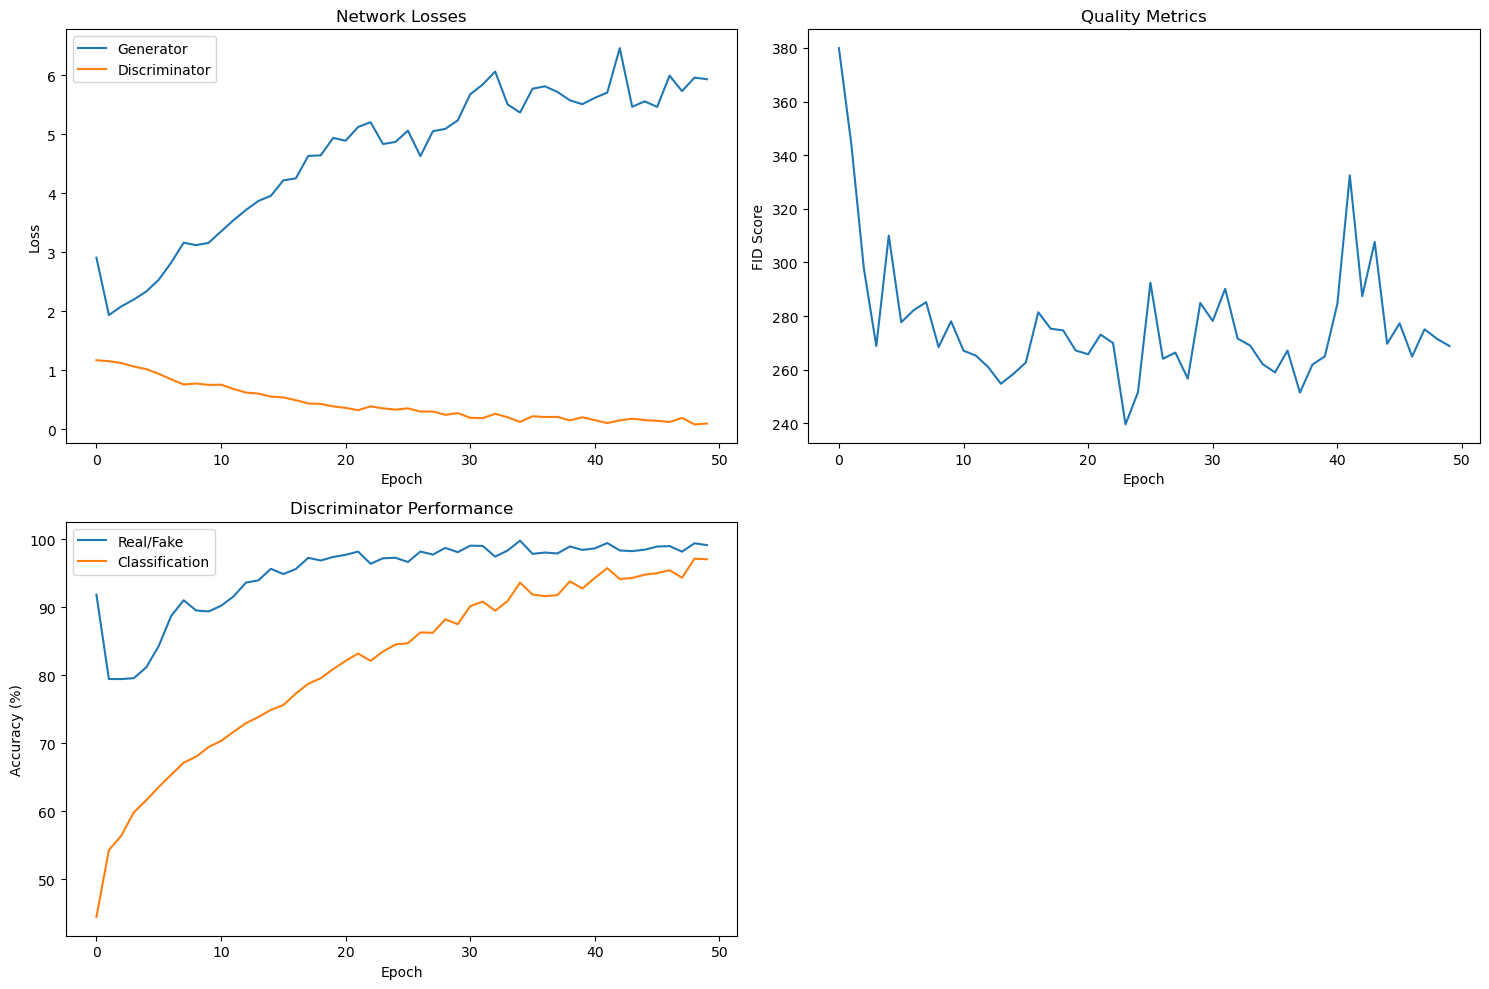


Training Completed
Final Metrics:
Generator Loss: 5.9301
Discriminator Loss: 0.1003
Discriminator Accuracy: 99.13%
Classification Accuracy: 97.05%
Quality Score: 268.8299


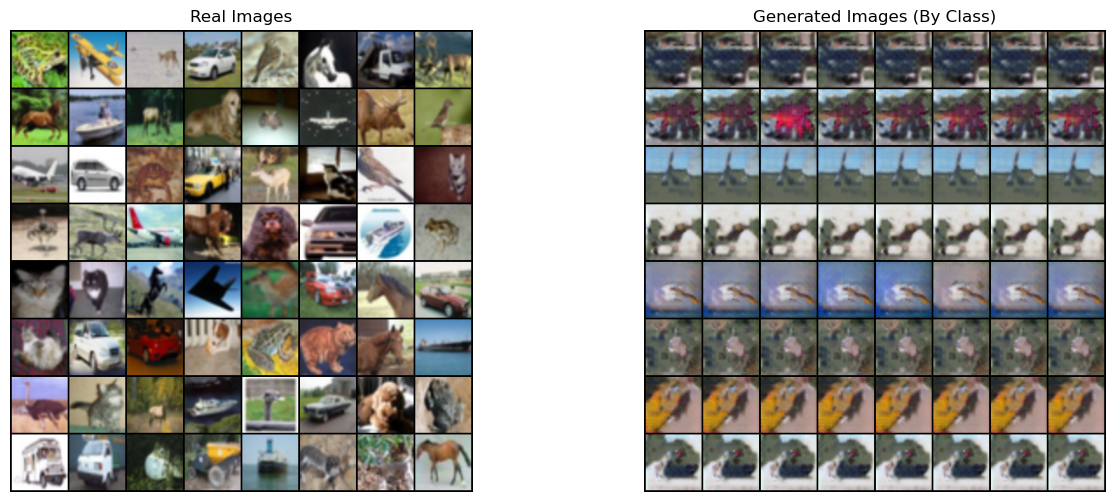


Results saved in ACGAN_results directory


In [6]:
# Cell 6: Execute Training and Display Final Results
# Initialize models
gen_model = Generator().to(device)
disc_model = Discriminator().to(device)
gen_model.apply(weight_init)
disc_model.apply(weight_init)

# Train models
print(f"Training on {device}")
gen_losses, disc_losses, class_accuracies, quality_metrics, disc_accuracies = train_networks(
    gen_model, disc_model, cifar_loader)

# Plot training curves
plot_training_curves(gen_losses, disc_losses, class_accuracies, quality_metrics, disc_accuracies)

print(f"\nTraining Completed")
print(f"Final Metrics:")
print(f"Generator Loss: {gen_losses[-1]:.4f}")
print(f"Discriminator Loss: {disc_losses[-1]:.4f}")
print(f"Discriminator Accuracy: {disc_accuracies[-1]:.2f}%")
print(f"Classification Accuracy: {class_accuracies[-1]:.2f}%")
print(f"Quality Score: {quality_metrics[-1]:.4f}")

# Display final comparison
with torch.no_grad():
    test_noise = torch.randn(64, MODEL_PARAMS['noise_dim'], 1, 1, device=device)
    test_labels = torch.tensor([i // 8 for i in range(64)], device=device)
    final_generated = gen_model(test_noise, test_labels)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(utils.make_grid(
        initial_samples[0][:64].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
    
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Generated Images (By Class)")
    plt.imshow(np.transpose(utils.make_grid(
        final_generated, padding=2, normalize=True).cpu(), (1, 2, 0)))
    
    plt.savefig(os.path.join(RESULTS_PATH, 'Metrics/final_comparison.png'))
    plt.show()

print("\nResults saved in ACGAN_results directory")